# Unet Trainer

This file main goal is to test function and classes for later use in training.
Is ignore entirely during the training

### Import Lib

In [1]:
# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator_J_pross import Preprocessed_Generator, Diff_Generator, LowLev, ColumGenerator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from utils import Sep_Var_show
from utils import Load_FLX_dict, Plot_Batch, F_and_plots, Plot_triple_diff_separated
from CST import CST

model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)
######
seed=0
batch_size=15
np.random.seed(seed)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
! rm TmpFolder_train --recursive
! mkdir TmpFolder_train

### Prepross

In [3]:
##### Kernels
from preprocess import Positive_Normalizer
TrainPath = '/media/victor/Elements/MVA/Stage/DataJac/TrainingData'
ValPath = '/media/victor/Elements/MVA/Stage/DataJac/TestData'

D=[Load_FLX_dict('DictPreprocess_fit.hdf5')]
Klist0 = []
Klist =[ProdKernel([('pl', 'o3')])]# FKernel(identity, ['ql']), FKernel(identity, ['qi']) ]

#D2 = [DictPrepross(['o3','pl','q'], 
#     [Level_Normalizer(False), Level_Normalizer(False), Level_Normalizer(False)] )]
#

D[0].dict['pl'] = Positive_Normalizer()
#D[0].dict['o3'] = Positive_Normalizer()
D[0].dict['t'] = Positive_Normalizer()
D[0].dict['emis'] = Positive_Normalizer()
D[0].dict['pl*o3'] = Positive_Normalizer()
#train_generator
train_generator = LowLev(folder=TrainPath, tmp_folder='TmpFolder_train/',batch_size=batch_size, preprocess_x=Klist, shuffle=1, custom_b_p_e=40*batch_size)
header_x = train_generator.used_variables
header_y = train_generator.variables_pred
D[0]['emis'].fit(train_generator[0][0][:,0])
D[0]['pl'].fit(train_generator[0][0][:,3])
D[0]['t'].fit(train_generator[0][0][:,9])
D[0]['pl*o3'].fit(train_generator[0][0][:,-1])
D[0]['qi'].fit(train_generator[0][0][:,5])
#p=D[0].to_array_save('Dict_Jac')
#fit_genator =FLX_Generator(folder=data_folder, batch_size=10*batch_size, train=True, preprocess_x=D+Klist0, custom_b_p_e=0)
#fit_genator.max_b=50
#D2[0].fitonGen(fit_genator, axis=2)
#del(fit_genator)

pair not found ('TmpFolder_train/f522_dh.trainingdata_in.lcv.20190401_0000z_is0001_js0061.hdf5', 'TmpFolder_train/jacobian_20190401_0000z_is0001_js0061.npy')


In [4]:
header_x

['emis', 'fcld', 'o3', 'pl', 'q', 'qi', 'ql', 'ri', 'rl', 't', 'ts', 'pl*o3']

In [5]:
#print(D[0])
#np.max(train_generator[0][0][:,5])
#train_generator[0][0][:,6])

In [6]:
moy=np.array([3.17977600e+07, 2.10195708e+00, 2.70822175e+06, 6.75992400e+06, 
              1.39000380e+07, 2.05309840e+07])
DY = DictPrepross([],[])
for i,n in enumerate(header_y):
    DY.dict[n] = Normalizer()
    DY.dict[n].set_params(0, moy[i]/10)

In [7]:
class ColumGenerator(Preprocessed_Generator):
    """docstring for ColumGenerator."""
    def __init__(self, folder, tmp_folder='TmpFolder', batch_size=64, shuffle=True, \
                 custom_b_p_e = 0, preprocess_x=[],preprocess_y=[], cut=36):
        self.cut=cut
        super(ColumGenerator, self).__init__(folder, tmp_folder, batch_size, shuffle, custom_b_p_e, preprocess_x, preprocess_y)


    def _reconfigure_outputs(self):
        super(ColumGenerator, self)._reconfigure_outputs()
        self.used_variables.append('Pert')

    def apply_preprocess_x(self,X):
        """
        Apply all the preprocess in the input data
        """
        X = super(ColumGenerator, self).apply_preprocess_x(X)
        X = X[:,:,self.cut:]
        return X

    def apply_preprocess_y(self,Y):
        """
        Apply all the preprocess in the output data
        """
        Y = super(ColumGenerator, self).apply_preprocess_y(Y) # shape : (bs, nvar, lev, lev)
        Y[:,:,1:,1:] = Y[:,:,1:,1:] - Y[:,:,1:,:-1] # 0 correspond to the upper layer and is always 0
        Y = Y[:, :, (self.cut-1):, self.cut:]
        return Y

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        # Generate indexes of the batch
        folder_id, file_id, el_id  = self.index_to_ids(index)
        self._update_next_file_ids(folder_id, file_id)
        folder_id = self.idx_folder[folder_id]
        file_id = self.idx_file[file_id]
        el_ids = self.idx_el[el_id*self.batch_size + np.arange(self.batch_size)]
        self.current_b = el_ids
        return self.__data_generation(folder_id, file_id, el_ids)

    def __data_generation(self, folder_id, file_id, el_ids):
        """
        Generates data containing batch_size samples, called at the end of __getitem__
        """
        self.reload(folder_id, file_id)
        # X
        X = self.X[el_ids]
        Pert = np.zeros((X.shape[0], 1, X.shape[2]))
        X = np.concatenate([X, Pert], axis=1)
        X = np.repeat(X, self.cut+1, axis=0)
        for p_lev in range(1 ,1+self.cut):
            for batch in range(self.batch_size):
                X[batch*self.cut+p_lev, -1, -p_lev]=1
        # Y
        Y = self.Y[el_ids].copy()
        Y[:, :, 0, :] = 0 #last element is 0, no perturbation
        Y = np.moveaxis(Y,[0,1,2,3],[-2,0,-1,1]); print(Y.shape)
        Y = Y.reshape(Y.shape[0], Y.shape[1], -1); print(Y.shape)
        Y = np.moveaxis(Y,-1,0)
        return X,Y

In [8]:
# V
V = [VarSuppression(['ts', 'o3'])]#, 'frocean', 'frlake','frland','frlandice', 'frseaice'])]

##### Full Preprocessing :
FP = Klist + D + V #D2 + V
#FP2 = D + Klist + D2 + V
from generator_J_pross import LowLevX
##### b_size
#train_generator = Preprocessed_Generator(folder=DataPath, tmp_folder='TmpFolder_train/',batch_size=batch_size, preprocess_x=FP, shuffle=1, custom_b_p_e=3888)
train_generator = ColumGenerator(folder=TrainPath, tmp_folder='TmpFolder_train/', 
                          batch_size=batch_size, preprocess_x=FP, preprocess_y=[DY],
                          shuffle=0, custom_b_p_e=60*batch_size)
validation_generator = ColumGenerator(folder=ValPath, tmp_folder='TmpFolder_test/',
                        batch_size=batch_size, preprocess_x=FP, preprocess_y=[DY],
                        shuffle=0, custom_b_p_e=train_generator.batch_per_file)
#validation_generator.max_b=500
#cold_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)
header_x = train_generator.used_variables
header_y = train_generator.variables_pred
in_channel=len(header_x)
o_channel = len(header_y)

In [9]:
#x,y = validation_generator[0]
x,y = train_generator[0]
#Plot_Batch(x,header_x+['p'], False)

(6, 36, 15, 37)
(6, 36, 555)


#WHAT IS ROLLAXIS ????
y0 = y.copy()
print(y0.shape)
y0 = np.moveaxis(y0,[0,1,2,3],[-2,0,-1,1]); print(y0.shape)
#y0 = y0.swapaxes(-1,-2)
y0 = y0.reshape(y0.shape[0], y0.shape[1], -1); print(y0.shape)
y0 = np.moveaxis(y0,-1,0); print(y0.shape)
#y0 = np.rollaxis(y0,-1); print(y0.shape)

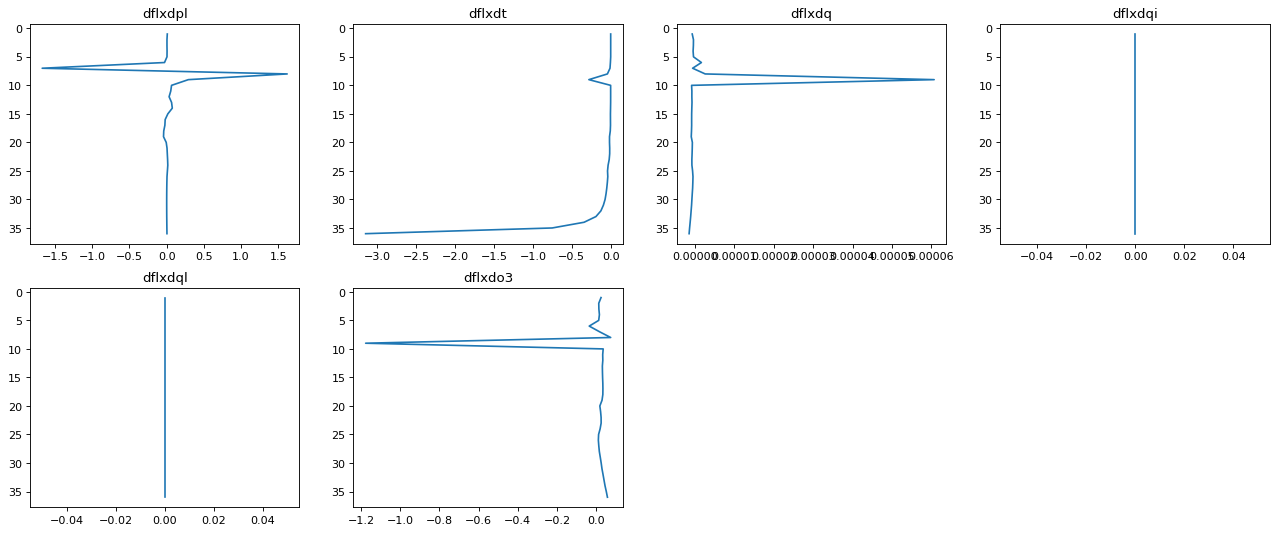

In [15]:
Plot_Batch(y[[36]], header_y, False)

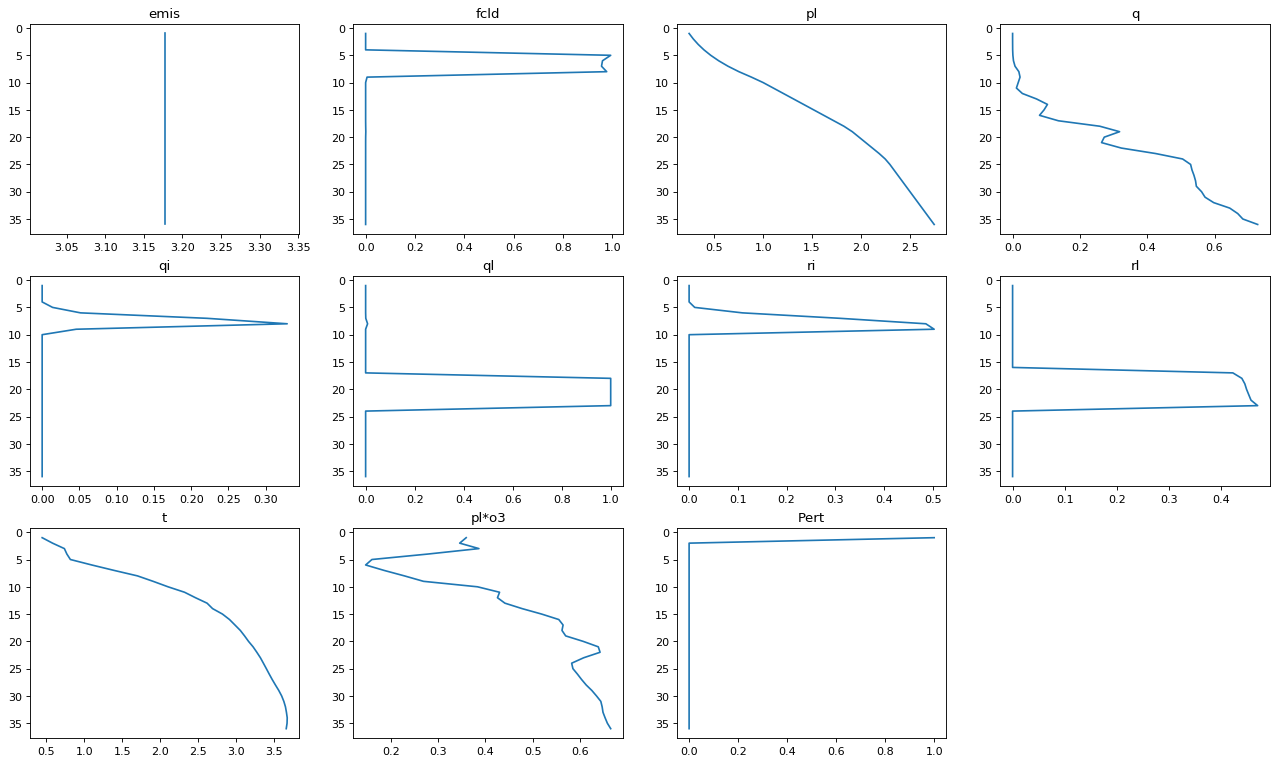

In [14]:
Plot_Batch(x[[36]], header_x, False)

In [13]:
header_x = train_generator.used_variables
header_y = train_generator.variables_pred

### Model construct

In [20]:
from CST import CST
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten, Input, TimeDistributed, Concatenate
from keras.layers import Conv1D, UpSampling1D, AveragePooling1D, SeparableConv1D, MaxPooling1D
from keras.layers import Bidirectional, Lambda, Reshape, SpatialDropout1D,Dropout
from keras.losses import mean_squared_error
from keras import backend as K
from keras import regularizers
import tensorflow as tf
import os
import numpy as np
from contextlib import redirect_stdout
from CST import CST
from architectures_utils import Name, Activation_Generator
from keras import layers
from keras.layers import Layer

expand = lambda x : K.expand_dims(x, axis=-2)
repeat = lambda x : K.repeat_elements(x, lev, axis=-2)

Expand = Lambda(expand)
Repeat = Lambda(repeat)

In [21]:
from contextlib import redirect_stdout
import keras.backend as K

from architectures import Unet_Act_Double, Bidir_Casual_Conv
from architectures_simples import Upsampler2D, Divide_Recombine, Divide_Substract, Perturbate
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Name
from keras import optimizers
import datetime
from keras.layers import UpSampling1D, UpSampling2D, AveragePooling2D, AveragePooling1D, SeparableConv2D
lev=36

####################################################
list_of_filters_unet =  [[64, 64, 128, 128], 
                         [30, 30, 50,  128], 
                         [50, 30],
                         [64, 128, 128, 256], 
                         [128, 64, 1]]
list_of_kernel_unet =  [[(30,3), (20,1), (10,1), (5,1)], 
                        [(2,1), (5,1), (2,1), (5,1)], 
                        [], 
                        [(3,3), (4,1), (3,1), (6,1)], 
                        [(10,1), (5,1), (3,1)]]
list_of_activations_unet =  [['elu', 'elu', 'elu','elu'], 
                             ['elu', 'elu', 'elu', 'elu'], 
                             ['tanh', 'tanh', 'tanh'], 
                             ['elu', 'elu', 'elu', 'elu'], 
                             ['elu', 'elu', 'linear']
                            ]
list_of_dropout =  [[0., 0., 0., 0., 0.], 
                       [0., 0., 0., 0, 0., 0.], 
                       [0., 0.], 
                       [0., 0., 0., 0., 0., 0.], 
                       [0., 0, 0]
                   ]
#################################################
list_of_filters_unet =  [[64, 64, 128, 128], 
                         [50, 30],
                         [128, 64, 1]]
list_of_kernel_unet =  [[(30,3), (20,1), (10,1), (5,1)], 
                        [(3,3), (4,1), (3,1), (6,1)], 
                        [(10,1), (5,1), (3,1)]]
list_of_activations_unet =  [['elu', 'elu', 'elu','elu'], 
                             ['elu', 'elu', 'elu', 'elu'], 
                             ['elu', 'elu', 'linear']
                            ]
list_of_dropout =  [[0., 0., 0., 0., 0.], 
                       [0., 0., 0., 0., 0., 0.], 
                       [0., 0, 0]
                   ]
###################################################

AE = False
if not AE:
    in_channel=10
else:
    in_channel=6
reg=1e-7
params_ae = [0.01]


Sint = [in_channel, 50, 100]

M_up  = Upsampler2D(avg=4, pooling=18, input_shape=(in_channel,lev, 1), data_format='channels_first')
M_sep = Sep_Conv2D( [(50,3), (40,3)], [Sint[1], Sint[2]], ['elu','elu'], params_ae, in_channel, 36, reg=0)
#M_bd  = Bidir_Casual_Conv2D()
M_unet =  Unet_Act_Double_2D(list_of_kernel_unet, 
                             list_of_filters_unet, 
                             list_of_activations_unet, 
                             list_of_dropout,
                             params_ae, Div=2, lev=36, in_channel=Sint[-1], reg=reg)
M = keras.Sequential()

if not AE:
    M.add(Expand)
    M.add(Repeat); M.layers[-1].name='Expanded';
    M.add(M_up)
    M.add(Perturbate()); M.layers[-1].name='Perturbate'
    M.add(M_sep); M.layers[-1].name='Sep'
    M.add(M_unet); M.layers[-1].name='Unet'
else:
    M.add(M_up)
    M.add(M_unet)

g = np.diag(np.ones(lev))/2
g = np.expand_dims(g, axis=0)
g = g.repeat(len(header_x), axis=0)
M.predict(x)
M.get_layer('Perturbate').set_weights([g])

In [24]:
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 10, 1, 36)         0         
_________________________________________________________________
Expanded (Lambda)            (None, 10, 36, 36)        0         
_________________________________________________________________
model_1 (Model)              multiple                  0         
_________________________________________________________________
Perturbate (Perturbate)      (None, 10, 36, 36)        12960     
_________________________________________________________________
Sep (Model)                  (None, 100, 36, 36)       13150     
_________________________________________________________________
Unet (Model)                 (None, 1, 36, 36)         2405962   
Total params: 2,432,072
Trainable params: 2,432,072
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras import optimizers
from keras.losses import mean_squared_error
from architectures_utils import LossHistory, Generate_Log
import datetime

moy=np.array([3.17977600e+07, 2.10195708e+00, 2.70822175e+06, 6.75992400e+06, 
              1.39000380e+07, 2.05309840e+07])

moy2=np.array([1.91889185e+07, 3.49157190e+00, 2.52286238e+06, 6.19959055e+06,
               1.25553556e+07, 2.11431788e+07])

def NormOutput(y, moy=moy):
    y0=y.copy()
    for i in range(6):
        y0[:,i]=2*y0[:,i]/moy[i]
    return(y0)

def JacLoss(ytrue, ypred):
    l = mean_squared_error(ytrue[:,0], ypred[:,0])
    for i in range(1,6):
        l+=mean_squared_error(ytrue[:,i], ypred[:,i])
    return l

def JacLossAE(ytrue, ypred, coef=moy):
    coef = tf.cast(coef, tf.float32)
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)
    l = mean_squared_error(10.*K.cumsum(ytrue[:,0]/coef[0], axis=-2),
                           10.*K.cumsum(ypred[:,0], axis=-1))
    for i in range(1,6):
        l+=mean_squared_error(10.*K.cumsum(ytrue[:,i]/coef[i], axis=-2), 
                              10.*K.cumsum(ypred[:,i]/coef[i], axis=-2))
    return l

def JacLossCM(ytrue, ypred, coef=moy):
    coef = tf.cast(coef, tf.float32)
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)
    l = mean_squared_error(K.cumsum(ytrue[:,0], axis=-2),
                           K.cumsum(ypred[:,0], axis=-1))
    for i in range(1,6):
        l+=mean_squared_error(K.cumsum(ytrue[:,i], axis=-2), 
                              K.cumsum(ypred[:,i], axis=-2))
    return l


def Jac1Loss1(ytrue, ypred, coef=moy,ide=1):
    coef = tf.cast(coef, tf.float32)
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)
    l = mean_squared_error(ytrue[:,ide], ypred)
    #10.*K.cumsum(ytrue[:,[ide]], axis=-2),
    #                       10.*K.cumsum(ypred, axis=-1))
    return l


archi = 'Unet_Double_bias'
ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, restore_best_weights=True)
prefix = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
LH = LossHistory(frequency=train_generator.batch_per_file, losses=['loss'])
Adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
M.compile(loss = Jac1Loss1, optimizer=Adam, metrics=[Jac1Loss1])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 10, 1, 36)         0         
_________________________________________________________________
Expanded (Lambda)            (None, 10, 36, 36)        0         
_________________________________________________________________
model_1 (Model)              multiple                  0         
_________________________________________________________________
Perturbate (Perturbate)      (None, 10, 36, 36)        12960     
_________________________________________________________________
Sep (Model)                  (None, 100, 36, 36)       13150     
_________________________________________________________________
Unet (Model)                 (None, 1, 36, 36)         2405962   
Total params: 2,432,072
Trainable params: 2,432,072
Non-trainable params: 0
_________________________________________________________________


In [27]:
history=M.fit_generator(train_generator,validation_data=validation_generator, callbacks=[ES, LH], shuffle=False, epochs=50)

Epoch 1/50
 120/1800 [=>............................] - ETA: 12:18 - loss: 87.4654 - Jac1Loss1: 87.4585

KeyboardInterrupt: 

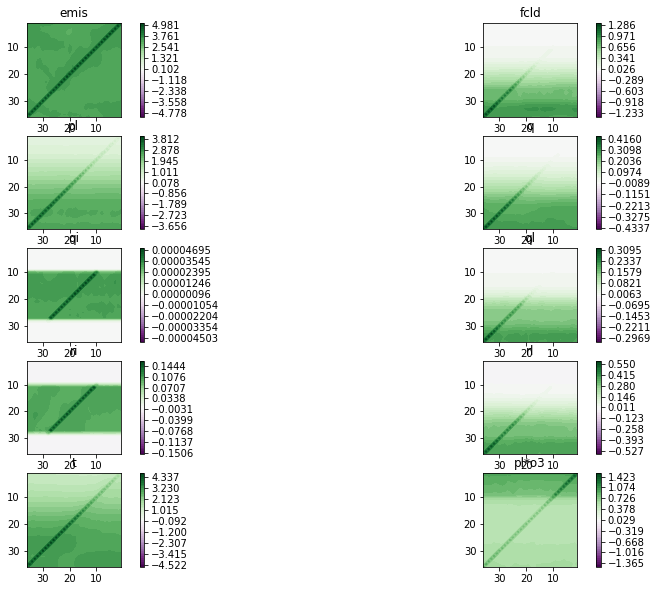

In [21]:
Mper = keras.Model(inputs=M.input, outputs=M.get_layer('Perturbate').get_output_at(0));
Mexp = keras.Model(inputs=M.input, outputs=M.get_layer('Expanded').get_output_at(0));;
Mexp = keras.Model(inputs=M.input, outputs=M.get_layer('Expanded').get_output_at(0));
y_per = Mper.predict(x);
y_dim = Mexp.predict(x);
F = F_and_plots(shape=(5,2));
Sep_Var_show(F, y_per[0], header_x);

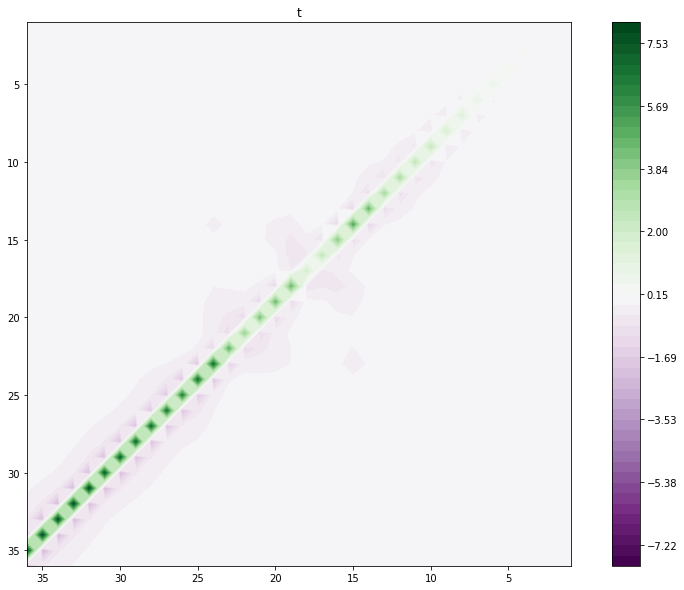

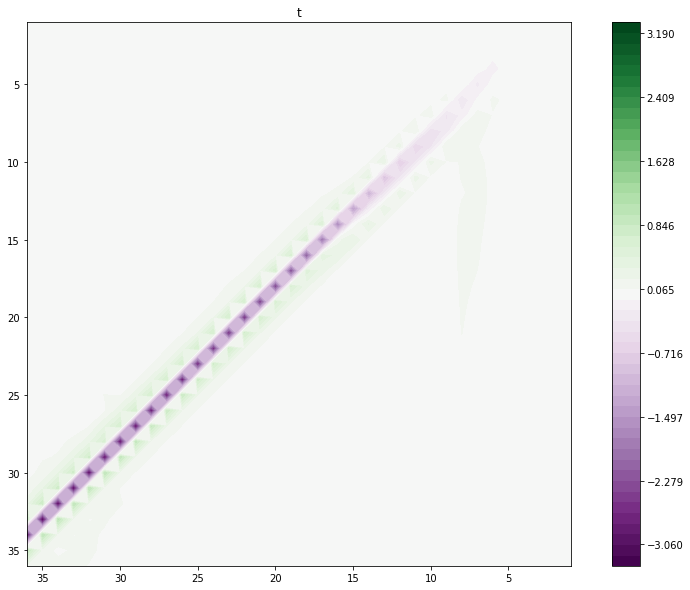

In [35]:
x,y = train_generator[0]
F = F_and_plots(shape=(1,1));
F0 = F_and_plots(shape=(1,1));
y0=M.predict(x);
Sep_Var_show(F, y[3,[1]], ['t'], False)
Sep_Var_show(F0, y0[3], ['t'], False)

In [54]:
def Jac1Loss1(ytrue, ypred, coef=moy,ide=1):
    coef = tf.cast(coef, tf.float32)
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)
    l = mean_squared_error(10.*K.cumsum(ytrue[:,ide]),
                           10.*K.cumsum(ypred[:,0]))
    l = K.sum(l, axis=-1)
    return l
C=K.get_value(Jac1Loss1(y,y0))

In [55]:
C[0]

2555.4136

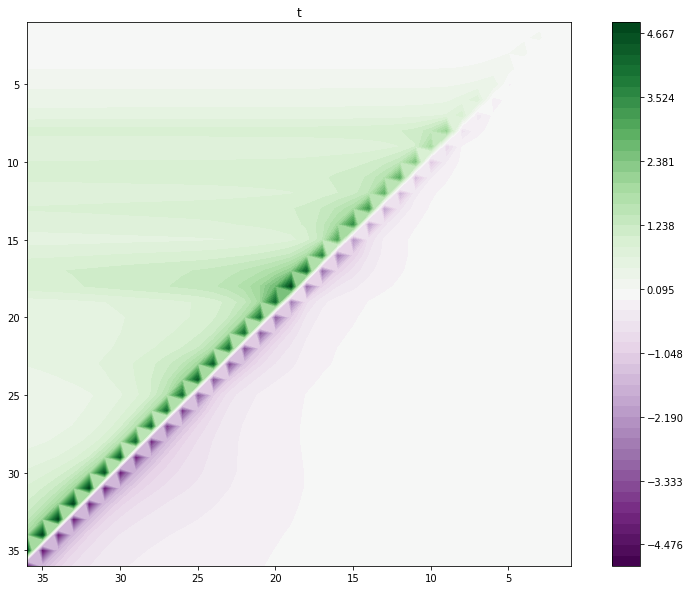

In [66]:
x,y = validation_generator[0]

y0=M.predict(x);

ycm = y.copy()
for i in range(6):
    ycm[:,i]=K.get_value(K.cumsum(y[:,i], axis=-1))
F0 = F_and_plots(shape=(1,1));
Sep_Var_show(F0, ycm[3, [1]], ['t'], False)

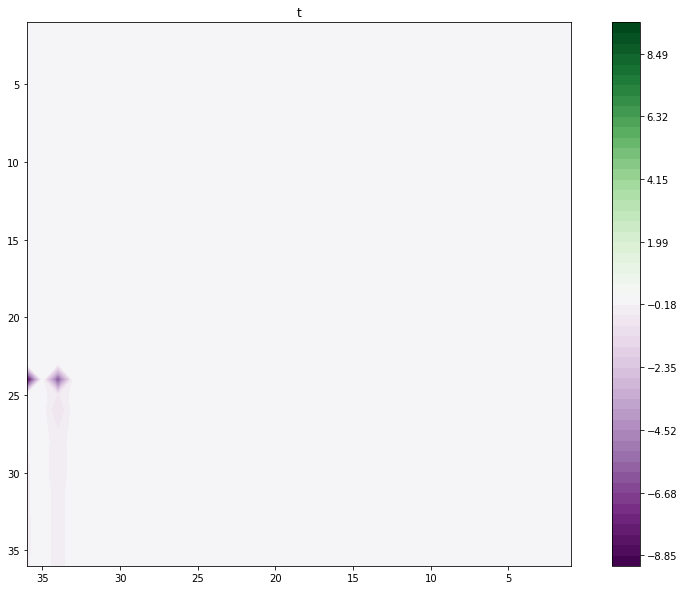

In [17]:
F0 = F_and_plots(shape=(1,1));
Sep_Var_show(F0, y[3, [0]], ['t'])

In [42]:
np.max(train_generator.X[:,7])

1.0

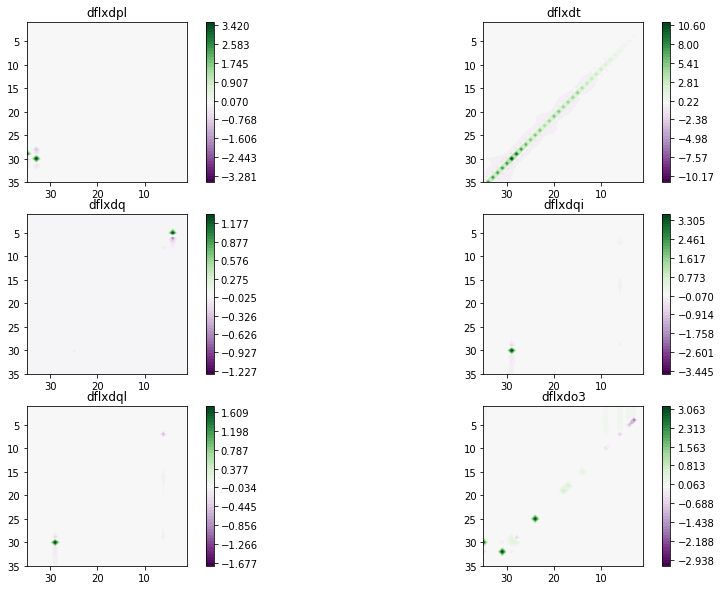

In [24]:
F = F_and_plots(shape=(3,2));
Sep_Var_show(F, y[10,:,1:,1:]-y[10,:,1:,:-1], header_y, True);

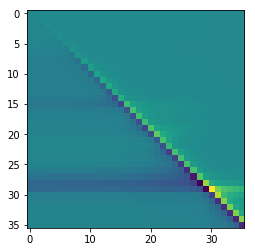

In [21]:
plt.imshow(y[10,1])

dflxdpl
['dflxdpl', 'dflxdt', 'dflxdq', 'dflxdqi', 'dflxdql', 'dflxdo3']


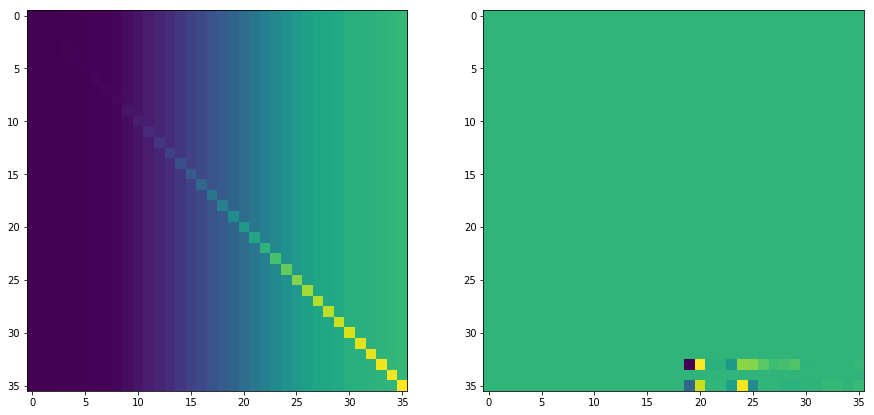

In [23]:
F = F_and_plots(shape=(1,2))
print(header_y[0])
print(header_y)
F[0].imshow(y_per[0,3])
F[1].imshow(y[0,0])

['emis', 'fcld', 'pl', 'q', 'qi', 'ql', 'ri', 'rl', 't', 'pl*o3']
['dflxdpl', 'dflxdt', 'dflxdq', 'dflxdqi', 'dflxdql', 'dflxdo3']


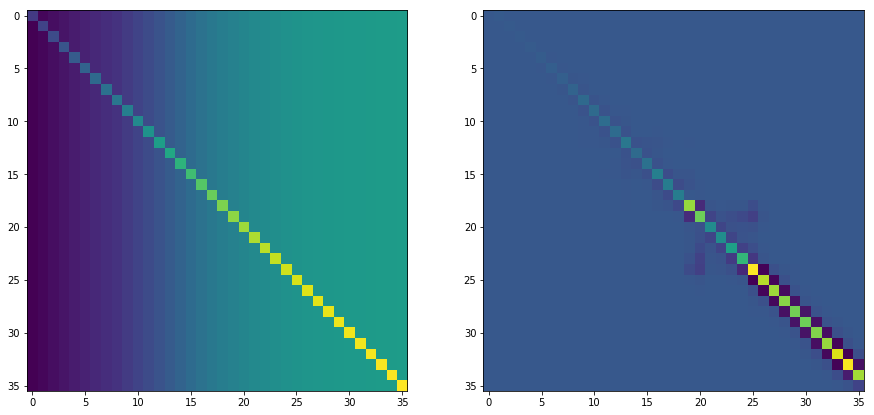

In [24]:
F = F_and_plots(shape=(1,2))
print(header_x)
print(header_y)
F[0].imshow(y_per[0,-2])
F[1].imshow(y[0,1]);

['emis', 'fcld', 'pl', 'q', 'qi', 'ql', 'ri', 'rl', 't', 'pl*o3']
dflxdq


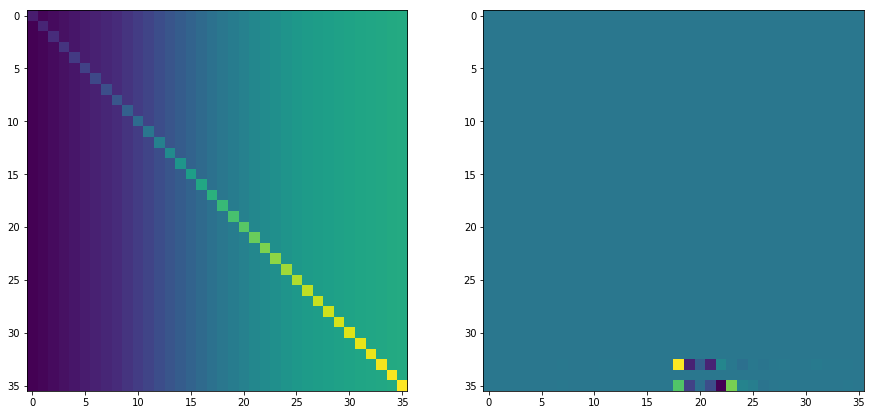

In [25]:
F = F_and_plots(shape=(1,2))
print(header_x)
print(header_y[2])
F[0].imshow(y_per[0,2])
F[1].imshow(y[2,0]);

['emis', 'fcld', 'pl', 'q', 'qi', 'ql', 'ri', 'rl', 't', 'pl*o3']
['dflxdpl', 'dflxdt', 'dflxdq', 'dflxdqi', 'dflxdql', 'dflxdo3']


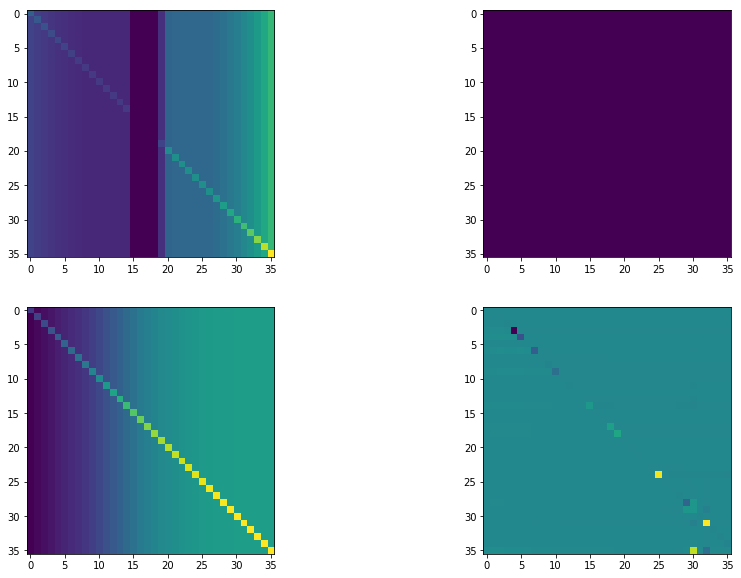

In [26]:
F = F_and_plots(shape=(2,2))
print(header_x)
print(header_y)
F[0].imshow(y_per[10,1])
F[1].imshow(y_per[10,6])
F[2].imshow(y_per[10,8])
F[3].imshow(y[10,5]);

['emis', 'fcld', 'pl', 'q', 'qi', 'ql', 'ri', 'rl', 't', 'pl*o3']
['dflxdpl', 'dflxdt', 'dflxdq', 'dflxdqi', 'dflxdql', 'dflxdo3']


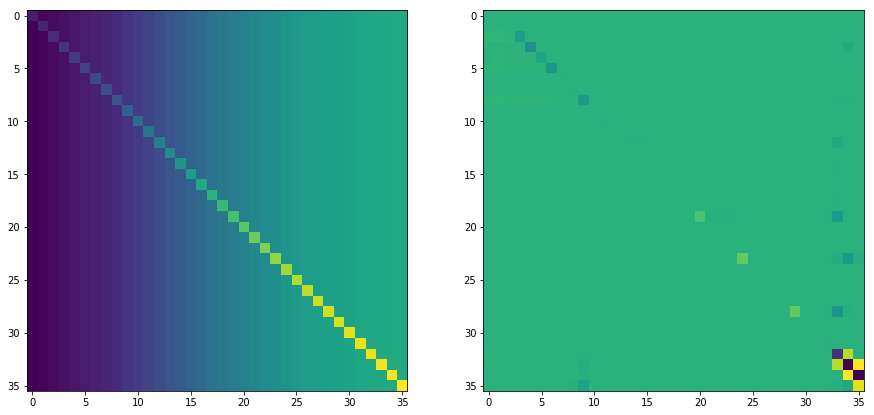

In [27]:
F = F_and_plots(shape=(1,2))
print(header_x)
print(header_y)
F[0].imshow(y_per[5,2])
F[1].imshow(y[5,5]);

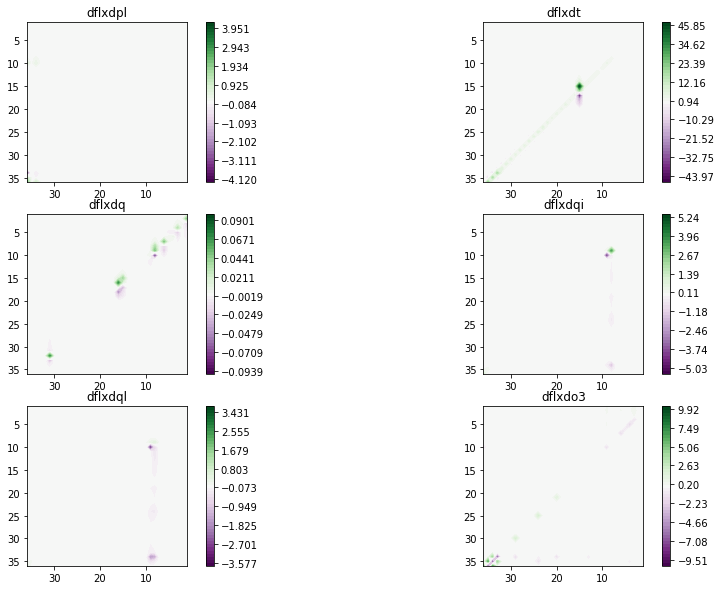

In [28]:
F = F_and_plots(shape=(3,2))
Sep_Var_show(F, y[5], header_y, True)

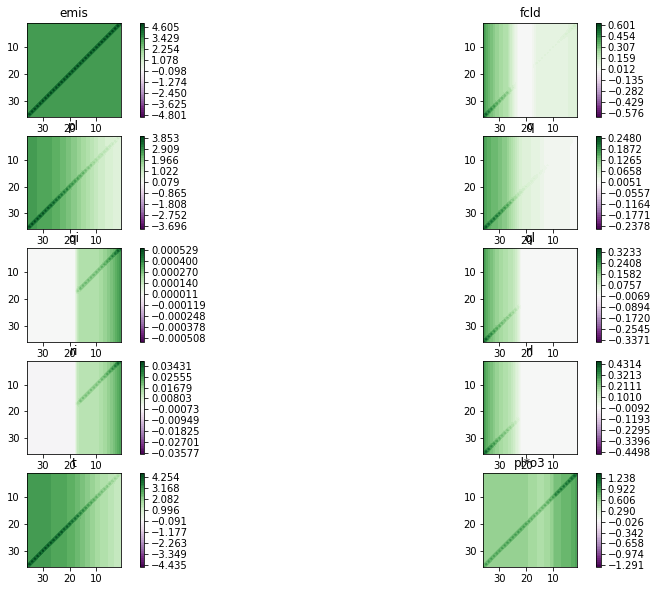

In [29]:
F = F_and_plots(shape=(5,2))
Sep_Var_show(F, y_per[5], header_x, False)

['emis', 'fcld', 'pl', 'q', 'qi', 'ql', 'ri', 'rl', 't', 'pl*o3']
['dflxdpl', 'dflxdt', 'dflxdq', 'dflxdqi', 'dflxdql', 'dflxdo3']


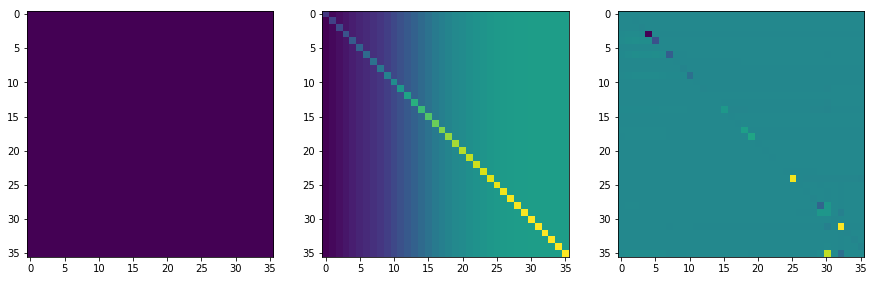

In [30]:
F = F_and_plots(shape=(1,3))
print(header_x)
print(header_y)
F[0].imshow(y_per[10,6])
F[1].imshow(y_per[10,8])
F[2].imshow(y[10,5]);

['emis', 'fcld', 'pl', 'q', 'qi', 'ql', 'ri', 'rl', 't', 'pl*o3']
['dflxdpl', 'dflxdt', 'dflxdq', 'dflxdqi', 'dflxdql', 'dflxdo3']


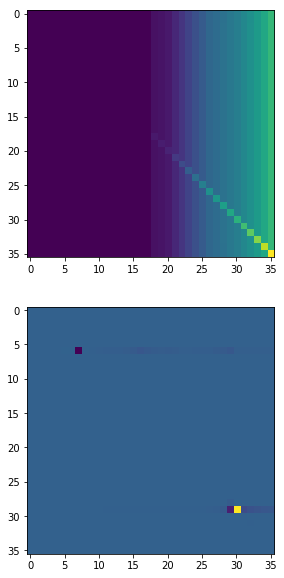

In [31]:
F = F_and_plots(shape=(2,1))
print(header_x)
print(header_y)
F[0].imshow(y_per[10,5])
F[1].imshow(y[10,4]);

In [14]:
header_y

['dflxdpl', 'dflxdt', 'dflxdq', 'dflxdqi', 'dflxdql', 'dflxdo3']

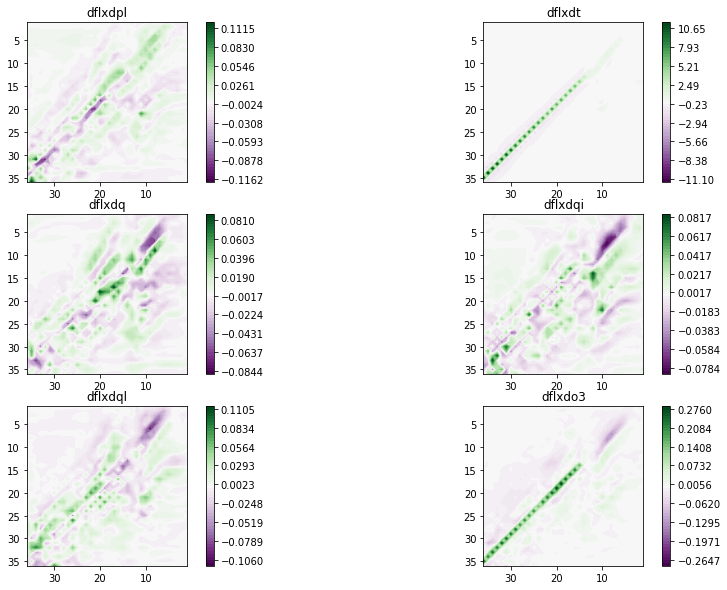

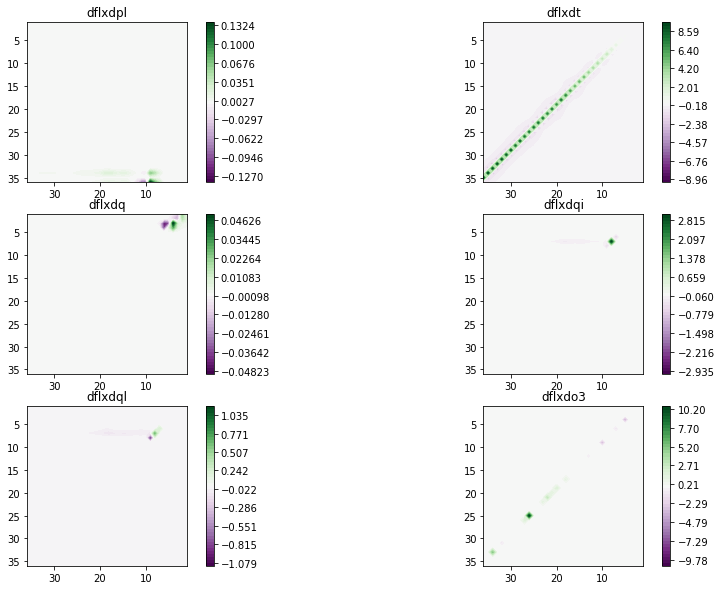

In [58]:
F0 = F_and_plots(shape=(3,2))
#y1=NormOutput(y)
Sep_Var_show(F0, y[1], header_y, False)

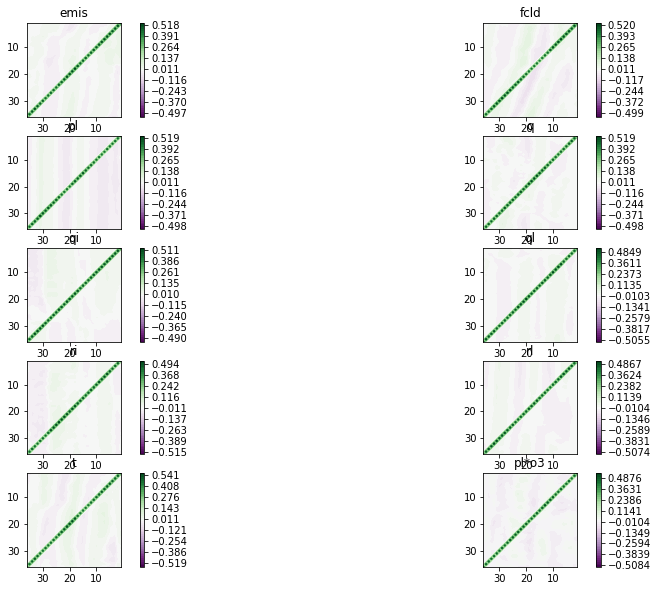

In [66]:
P=K.get_value(M.get_layer('Perturbate').kernel)
F0 = F_and_plots(shape=(5,2))
Sep_Var_show(F0, P, header_x, False)

In [ ]:
# IMPORTANT MODEL LOG SAVER
archi='Unet_Cumulative_Direct_1loss'
file = os.path.join(log_folder, prefix+archi+'.txt')
M.save_weights(os.path.join(model_folder, prefix+archi))
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        M.summary
        for i, model in enumerate(M.layers):
            if( str(type(model)) == '<class \'keras.engine.training.Model\'>'):
                model.summary()
        print('\n')
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_unet)
        print('list_of_kernel_unet = ',list_of_kernel_unet)
        print('list_of_activations_unet = ', list_of_activations_unet)
        print('list_of_dropout = ', list_of_dropout)
        for loss in LH.losses:
            print(loss)
            print(LH.losses[loss])
        print(history.history)

In [ ]:
flxu_loss_h = LH.losses['loss'][2:-1].copy()
flxu_loss_h[-1]/=LH.frequency
#flxd_loss_h = LH.losses['flxd_loss'][1:-1].copy()
#flxu_loss_h[12]*=0
#flxu_loss_h[13]*=0
#flxu_loss_h[13]*=0

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(flxu_loss_h)
ax.plot(history.history['val_loss'])
#ax.plot(flxd_loss_h)
ax.grid()
#ax.plot(loss)
#ax.set_yscale('log')
ax.legend(['train loss', 'test loss'])

In [ ]:
#FP2 = D + Klist + D2 + V
#validation_generator = FLX_Generator(folder='Data4', batch_size=batch_size, train=True, preprocess_x=FP, shuffle=1)
#validation_generator.batch_size = validation_generator.batch_size*validation_generator.batch_per_file
#validation_generator.batch_per_filef
F_mse=[]
for i, (x,y) in enumerate(validation_generator):
    print(i/len(validation_generator)*100)
    y0 = M.predict(x)
    F_mse.append(K.get_value(Up_Down_loss(y,y0)))
F_mse=np.array(F_mse)

In [ ]:
from CST import CST
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Flatten, Input, TimeDistributed, Concatenate
from keras.layers import Conv1D, UpSampling1D,  SeparableConv1D, MaxPooling1D, Dropout,AveragePooling1D
from keras.layers import UpSampling2D, Conv2D, AveragePooling2D

from keras.layers import Bidirectional, Lambda, Reshape, SpatialDropout1D
from keras.losses import mean_squared_error
from keras import backend as K
from keras import regularizers
import tensorflow as tf
import os
import numpy as np
from contextlib import redirect_stdout
from CST import CST
from architectures_utils import Name, Activation_Generator

K.set_image_data_format('channels_first')
def Unet_Act_Double_2D(list_of_kernels_s, list_of_filters, list_of_activations, list_of_dropout,
                       params=[], Div=3, lev=CST.lev(CST), in_channel=11, reg=0.0,
                       data_format='channels_first'):
    """
    Generate a Unet-Archictecture:
    list_of_kernels : list of 3 lists containing the kernel size for convolution
    list_of_filters : list of 3 lists containing the number of filters for convolution
    list_of_activations : list of 3 list containing the names of the activation function
    list_of_dropout : list of 3 list containing the proportion of the dropout
    params : params used for activation
    Div : number of downscaling
    in_channel : number of inputs
    reg : weights regularizers (should be 0 if you use dropout)
    """
    AG = Activation_Generator()
    Sizes = [ len(list_of_filters[i]) for i in range(len(list_of_filters)) ]
    if data_format=='channels_first':
        concat_axis=1
    else:
        concat_axis=-1
#First Convolutions
    Conv_l0 = [Input(name='Origin_Input', dtype='float32', shape=(in_channel, lev, lev))]
    for i in range(Sizes[0]):
        Conv_l0.append(Conv2D(filters=list_of_filters[0][i], kernel_size=list_of_kernels_s[0][i],
                            padding='same', use_bias=False, name=Name('Conv', i),
                            kernel_regularizer=regularizers.l1(reg),
                            data_format=data_format)(Conv_l0[-1]))
        Conv_l0.append( AG(list_of_activations[0][i], Name(list_of_activations[0][i], i), params)(Conv_l0[-1]))
        Conv_l0.append(Dropout(list_of_dropout[0][i])(Conv_l0[-1]))

# DownScaling
    Conv_l1 = [Conv_l0[-1]]
    for i in range(Sizes[1]//2):
        Conv_l1.append(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='same', name=Name('AVG', i+100))(Conv_l1[-1]))
        Conv_l1.append(Conv2D(filters=list_of_filters[1][2*i], kernel_size=list_of_kernels_s[1][2*i],
                               padding='same', name=Name('Conv', i+100),data_format=data_format)(Conv_l1[-1] ))
        Conv_l1.append(AG(list_of_activations[1][2*i], Name(list_of_activations[1][2*i], 100+i), params )(Conv_l1[-1]) )
        Conv_l1.append(Dropout(list_of_dropout[1][2*i])(Conv_l1[-1]))

        Conv_l1.append(Conv2D(filters=list_of_filters[1][2*i+1], kernel_size=list_of_kernels_s[1][2*i+1],
                               padding='same', name=Name('Conv', 110+i),data_format=data_format)(Conv_l1[-1]) )
        Conv_l1.append(AG(list_of_activations[1][2*i+1], Name(list_of_activations[1][2*i+1], 110+i), params )(Conv_l1[-1]))
        Conv_l1.append(Dropout(list_of_dropout[1][2*i+1])(Conv_l1[-1]))

# Operation done on the small dimension : here fc
    Conv_l2 = [(Conv_l1[-1])]
    for i in range(Sizes[2]):
        Conv_l2.append(Conv2D(filters=list_of_filters[2][i], kernel_size=(int(lev/2**Div), int(lev/2**Div)),
                               padding='same', name=Name('Dense', i), data_format=data_format)(Conv_l2[-1]))
        Conv_l2.append(AG(list_of_activations[2][i], list_of_activations[2][i]+'_d_'+str(i), params)(Conv_l2[-1]))
        Conv_l2.append(Dropout(list_of_dropout[2][i])(Conv_l2[-1]))
    Conv_l3 = [Conv_l2[-1]]

# Upsampling and concats
    for i in range(Sizes[3]//2):
        Conv_l3.append( Concatenate( name=Name('Concat',i+300),axis=concat_axis )([Conv_l3[-1], Conv_l1[-(1+i*7)]]))
        Conv_l3.append(UpSampling2D(size=(2, 2), name=Name('Ups',i+200))(Conv_l3[-1]))
        Conv_l3.append(Conv2D(filters=list_of_filters[3][2*i], kernel_size=list_of_kernels_s[3][2*i], padding='same',
                               name=Name('Conv', i+200), data_format=data_format)(Conv_l3[-1] ))
        Conv_l3.append( AG(list_of_activations[3][2*i], Name(list_of_activations[3][2*i], 200+i), params )(Conv_l3[-1]) )
        Conv_l3.append(Dropout(list_of_dropout[3][2*i])(Conv_l3[-1]))

        Conv_l3.append(Conv2D(filters=list_of_filters[3][2*i+1], kernel_size=list_of_kernels_s[3][2*i+1], padding='same',
                               name=Name('Conv', i + 210), data_format=data_format)(Conv_l3[-1]))
        Conv_l3.append(AG(list_of_activations[3][2*i+1], Name(list_of_activations[3][2*i+1], 210 + i), params)(Conv_l3[-1]))
        Conv_l3.append(Dropout(list_of_dropout[3][2*i+1])(Conv_l3[-1]))

# Last Conv layers
    Conv_l4 = [Conv_l3[-1]]
    for i in range(Sizes[4]):
        Conv_l4.append(Conv2D(filters=list_of_filters[4][i], kernel_size=list_of_kernels_s[4][i],
                            padding='same', use_bias=False, name=Name('Conv3',i+300),
                            activity_regularizer=regularizers.l2(reg), data_format=data_format)(Conv_l4[-1]))

        Conv_l4.append( AG(list_of_activations[4][i], Name(list_of_activations[4][i], 300+i), params )(Conv_l4[-1]) )
        Conv_l4.append(Dropout(list_of_dropout[4][i])(Conv_l4[-1]))
    return keras.Model(Conv_l0[0], Conv_l4[-1])

In [ ]:
from utils import F_and_plots, Plot_diff

x, y = validation_generator[51]
y0 = M.predict(x)

In [ ]:
y=np.expand_dims(y,axis=-1)
y0=np.expand_dims(y0,axis=-1)

In [ ]:
F = F_and_plots(shape=(1,2))
Plot_diff(F, np.cumsum(y[:,0:], axis=1),
          np.cumsum(y0[:,0:], axis=1),header_y=['flx'], J=[0,1])

In [ ]:
plt.plot(y[1,:])
plt.plot(y0[1,:])

In [ ]:
plt.plot(y[0,:])
plt.plot(y0[0,:])

In [ ]:
F = F_and_plots(shape=(1,2))
Plot_diff(F, y[:,1:], 
          y0[:,1:],header_y=['flx'], J=[0,1])

In [ ]:
y[:,1]

In [ ]:
yc = np.cumsum(y[:,:-1], axis=1)
y0c = np.cumsum(y0[:,:-1], axis=1)

F = F_and_plots(shape=(1,2))
Plot_diff(F, yc[:,:-1], y0c[:,:-1],header_y=['flx'], J=[0,1])

In [ ]:
l1=[]
for x,_ in validation_generator:
    l1.append(x[0,-1,-1])
validation_generator.on_epoch_end()
l2=[]
for x,_ in validation_generator:
    l2.append(x[0,-1,-1])
l1=np.array(l1)
l2=np.array(l2)

In [ ]:
from utils import F_and_plots, Plot_diff
x,y = validation_generator[0]
y0 = M.predict(x)

J=[0,1,2]
F = F_and_plots(shape=(1,3))
y_0 = np.expand_dims(y0[[J]], axis=-1)
y_t = np.expand_dims(y[[J]], axis=-1)
Plot_diff(F, y_t, y_0, header_y=['flx'], J=J)

In [ ]:
y_0.shape

from tqdm import tqdm 

def Plot_Earth(M, generator, prec):
    i=0
    MSE=[]
    for x, _ in tqdm(generator):
        y0 = M.predict(x)
        MSE.append(y0)
    MSE = np.array(MSE)
    return(MSE)

train_generator =  Full_Diff_Generator(folder='Data2/', 
                                       batch_size=train_generator.batch_per_file*train_generator.batch_size,
                                       train=True, 
                                         preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0, custom_b_p_e=25)
V = Plot_Earth(M, train_generator, 5)
V=np.array(V)
np.save('pred_best_Unet_serveur',V)

In [ ]:
from utils import F_and_plots, Plot_diff
#M.load_weights('BestModels/Best_Unet(serveur)')

i=np.random.randint(len(validation_generator))
x,y=validation_generator[i]
y0 = M.predict(x)
y0 = np.expand_dims(y0,axis=-1)
y = np.expand_dims(y,axis=-1)
J=np.arange(4)
Plot_diff( F_and_plots(shape=(1,len(J))), y,y0, header_y=['flx'], J=J)

In [ ]:
Plot_diff( F_and_plots(shape=(1,1)), y,y0, header_y=['flx'], J=[4])

In [ ]:
MSE_e=K.get_value(Up_Down_loss(y,y0))
MSE_e = np.mean(MSE_e, axis=1)
np.argmin(MSE_e)

In [ ]:
validation_generator.batch_size = int(validation_generator.batch_per_file*validation_generator.batch_size)
train_generator.batch_size = int(train_generator.batch_per_file*train_generator.batch_size)

In [ ]:
X,Y = validation_generator[0]
Y0 = M.predict(X)
MSE_e = K.get_value(Up_Down_loss(Y0,Y))

In [ ]:
for x,y in train_generator[0]

In [ ]:
MSE_e.shape

In [ ]:
plt.hist(MSE_e, bins=500, cumulative=True);

In [ ]:
X,Y = validation_generator[0]
Y0 = M.predict(X)
MSE_e = K.get_value(Up_Down_loss(Y0,Y))
del(X,Y)
y_argmin = np.argmin(MSE_e)
validation_generator.batch_size = 32
x,y = validation_generator[y_argmin//32]
y0 = M.predict(x)
m = K.get_value(Up_Down_loss(y,y0))
xmin = x[[np.argmin(m)]]

In [ ]:
Plot_Batch(xmin, header_x)

In [ ]:
def Jacobian(M,x, dt):
    """
    Compute the Jacobian of x
    x has shape (1, lev, n_var)
    M product an output of size (1, lev)
    """
    _, lev, n_var= x.shape
    Jac = np.zeros((n_var, lev, lev))
    P0 = np.zeros((lev*n_var, lev))
    # could be more optimize [l steps instead of l*n_var]
    for v in range(n_var):
        for l in range(lev):
            x0 = x.copy()
            x0[0,l , v] += 1/dt
            P0[v*lev+l] = M.predict(x0)
    P1 = M.predict(x)
#    print(P0[0] - P1[0])
    return (P1-P0).T

J = Jacobian(M, xmin, 10000)

In [ ]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,J, header_x)
J2 = Divide(J, header_x)

In [ ]:
for i in J2:
    print(np.max(i), np.min(i))

In [ ]:
import tqdm
G=[]
for i in tqdm.tqdm(range(72)):
    gradients = K.gradients(M.get_output_at(0)[:,i],M.input)
    gradients_f = K.function( [M.input] , [gradients[0]] )
    G.append(gradients_f([x[[0]]])[0])

G=np.array(G)
G = G[:,0,:,:]
G0 = G.swapaxes(1,2)
G0 = G0.reshape(72,720)

In [ ]:
G0 = np.load('Tf_grad_best_model.npy')

In [ ]:
from utils import Sep_Var_show, Sep_Var_Gradient

In [ ]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,G0, header_x)

In [ ]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,-J, header_x)

In [ ]:
F=F_and_plots(figsize=(15,8), shape=(2,5))
Sep_Var_show(F,10000*J+G0, header_x)

In [ ]:
for j,i in enumerate(G2-J2):
    print(header_x[j], np.max(i), np.min(i))

In [ ]:
for j,i in enumerate(G2):
    print(header_x[j], np.max(i), np.min(i))

In [ ]:
for j,i in enumerate(J2*10000):
    print(header_x[j], np.max(i), np.min(i))

In [ ]:
from generator import Full_Diff_Generator
test_gen = Full_Diff_Generator(folder='Data3', batch_size=batch_size, train=False, preprocess_x=FP, chosen_var=['flxd', 'flxu'], shuffle=0)
test_gen.list_files = [24]

In [ ]:
import tensorflow as tf
# CHECKING IMPACT OF LOWER LAYER
x,y = test_gen[100]

y0 = M.predict(x)

i = M_Up.get_input_at(0)
o = M_Up.get_output_at(0)

Up_model = K.function([i],[o])

i1 = M_unet.get_input_at(0)
o1 = M_unet.get_output_at(0)

o2 = M_unet.get_layer('Reshape').output
o3 = M_unet.get_layer('elu_301').get_output_at(0)
o4 = M_unet.get_layer('Conv3_301').get_output_at(0)
o5 = M_unet.get_layer('linear_302').get_output_at(0)

Second_model = K.function( [i1],[o1])
Dense_layer = K.function( [i1],[o2])
Antepen_layer = K.function( [i1],[o3])
#Last_layer = K.function( [i1],[o4])
Last_layer = K.function( [i1],[o5])


#img = Dense_layer(First_model([x]))[0]
img = Last_layer( Up_model([x]))[0]

#Antepen_layer(Up_model([x]))[0]
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)
ax.imshow((np.mean(abs(img),axis=0).T))
#F = K.function(I,O)
#F([tf.cast(x,tf.float32)])

In [ ]:
def Plot_diff(F, y,y0, header_y, lev=72, J = [0], titles=False):
    for l in range(len(header_y)):
        for ind,i in enumerate(J):
            F[ind*len(header_y) + l].plot(np.flip(y[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].plot(np.flip(y0[i,:,l].T) , np.arange(lev))
            F[ind*len(header_y) + l].legend(["truth", "pred"])
            if titles !=False:
                F[ind*len(header_y) + l].set_title(header_y[l] + ' '+ str(titles[ind]))
                

J=[5,8,9]
F = F_and_plots(figsize=(5*2,len(J)*8), shape=(len(J), 2))
Plot_diff(F, y, img, ['flxd', 'flxu'], J=J, titles=J)

In [ ]:
F = F_and_plots(figsize=(15,10), shape=(1,len(J)))
Plot_diff(F, y[:,:,[0]]-y[:,:,[1]], y0.reshape(32,72,1), ['flx'], J=J, titles=J)

In [ ]:
y0.shape